# Transformer Network

A neural network which takes advantage of parallel-processing and allows to substantially speed up the training process.

In [1]:
# Import Required Lib's
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization

## 1 - Positional Encoding

In sequence to sequence tasks, the relative order of where data is extremely important to its meaning. When we were training sequential neural networks such as RNNs, We fed our inputs into the network in order. Information about the order of our data was automatically fed into our model.  However, when we train a Transformer network, we feed our data into the model all at once. While this dramatically reduces training time, there is no information about the order of our data. This is where positional encoding is useful - we can specifically encode the positions of our inputs and pass them into the network using these sine and cosine formulas:

$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1} $$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2} $$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $i$ refers to each of the different dimensions of the positional encoding.

The values of the sine and cosine equations are small enough (between -1 and 1) that when we add the positional encoding to a word embedding, the word embedding is not significantly distorted. The sum of the positional encoding and word embeding is ultimately what is fed into the model. Using a combination of these two equations helps our Transformer network attend to the relative positions of our input data. Note that while in the lectures Andrew uses vertical vectors but in this assignment, all vectors are horizontal. All matrix multiplications should be adjusted accordingly.

<a name='1-1'></a>
### 1.1 - Sine and Cosine Angles

Get the possible angles used to compute the positional encodings by calculating the inner term of the sine and cosine equations:

$$\frac{pos}{10000^{\frac{2i}{d}}} \tag{3}$$

(1, 50, 512)


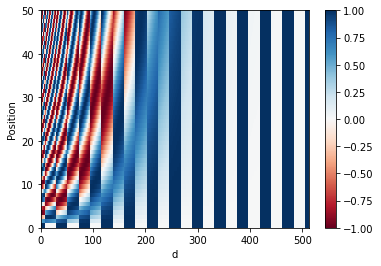

In [2]:
# Get Angles for sine and cosine positional encodings
def get_angles(pos, i, d):
    """
    Get the angles for the positional encoding

    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        i --   Row vector containing the dimension span [[0, 1, 2, ..., M-1]]
        d(integer) -- Encoding size

    Returns:
        angles -- (pos, d) numpy array
    """
    angles = pos / (np.power(10000, (2 * (i//2)) / np.float32(d)))

    return angles


def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings

    Arguments:
        positions (int) -- Maximum number of positions to be encoded
        d (int) -- Encoding size

    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[ np.newaxis, :],
                            d)

    # -> angle_rads has dim (positions, d)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

# Test
pos_encoding = positional_encoding(50, 512)

print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim(0, 512)
plt.ylabel('Position')
plt.colorbar()
plt.show()

Each row represents a positional encoding - notice how none of the rows are identical! we have created a unique positional encoding for each of the words.

## 2 - Masking

There are two types of masks that are useful when building our Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in our input sentence.

### 2.1 - Padding Mask

Oftentimes our input sequence will exceed the maximum length of a sequence our network can process. Let's say the maximum length of our model is five, it is fed the following sequences:

    [["Do", "we", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"],
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

which might get vectorized as:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]

When passing sequences into a transformer model, it is important that they are of uniform length. we can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of our model:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]

Sequences longer than the maximum length of five will be truncated, and zeros will be added to the truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum length, they zeros will also be added for padding. However, these zeros will affect the softmax calculation - this is when a padding mask comes in handy! By multiplying a padding mask by -1e9 and adding it to our sequence, we mask out the zeros by setting them to close to negative infinity.

After masking, our input should go from `[87, 600, 0, 0, 0]` to `[87, 600, -1e9, -1e9, -1e9]`, so that when we take the softmax, the zeros don't affect the score.

In [3]:
def create_padding(seq):
    """
    Creates a matrix mask for the padding cells

    Arguments:
        seq -- (n, m) matrix

    Returns:
        mask -- (n, 1, 1, m) binary tensor
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # Add extra dimensions to add the padding to the attention logits
    return seq[:, tf.newaxis, tf.newaxis, :]

### 2.2 - Look-ahead Mask

The look-ahead mask follows similar intuition. In training, we will have access to the complete correct output of our training example. The look-ahead mask helps our model pretend that it correctly predicted a part of the output and see if, *without looking ahead*, it can correctly predict the next output.

For example, if the expected correct output is `[1, 2, 3]` and we wanted to see if given that the model correctly predicted the first value it could predict the second value, we would mask out the second and third values. So we would input the masked sequence `[1, -1e9, -1e9]` and see if it could generate `[1, 2, -1e9]`.

In [4]:
def create_look_ahead_mask(size):
    """
    Returns an upper triangular matrix filled with ones

    Arguments:
        size -- matrix size

    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

## 3 - Self-Attention

As the authors of the Transformers paper state, "Attention is All we Need".

<img src="self-attention.png" alt="Encoder" width="600"/>
<center><b>Figure 1: Self-Attention calculation visualization</font></center></b>

The use of self-attention paired with traditional convolutional networks allows for the parallelization which speeds up training. We will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to return rich, attention-based vector representations of the words in our sequence. This type of self-attention can be mathematically expressed as:
$$ \text {Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\ $$

* $Q$ is the matrix of queries
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask we choose to apply
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

In [5]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      - q, k, v must have matching leading dimensions.
      - k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      - The mask has different shapes depending on its type(padding or look ahead) but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    # Q*K'
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)   # (..., seq_len_q, seq_len_k)

    # attention_weights * V
    output = tf.matmul(attention_weights, v)   # (..., seq_len_q, depth_v)

    return output, attention_weights

## 4 - Encoder

The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder. we will implement the Encoder by pairing multi-head attention and a feed forward neural network (Figure 2a).
<img src="encoder_layer.png" alt="Encoder" width="250"/>
<center><b>Figure 2a: Transformer encoder layer</font></center></b>

* `MultiHeadAttention` we can think of as computing the self-attention several times to detect different features.
* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`

our input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.

* For the `MultiHeadAttention` layer, we will use the [Keras implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). If we're curious about how to split the query matrix Q, key matrix K, and value matrix V into different heads, we can look through the implementation.
* We will also use the [Sequential API](https://keras.io/api/models/sequential/) with two dense layers to build the feed forward neural network layers.


### 4.1 Encoder Layer

Now we can pair multi-head attention and feed forward neural network together in an encoder layer! We will also use residual connections and layer normalization to help speed up training (Figure 2a).

In [6]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
                                tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])


class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism, followed by a simple, positionwise fully connected feed-forward network.
    This architecture includes a residual connection around each of the two sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)
        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer

        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # calculate self-attention using mha
        #-> To compute self-attention Q, V and K should be the same (x)
        self_attn_output = self.mha(x, x, x, mask)  # Self attention (batch_size, input_seq_len, embedding_dim)

        # apply dropout layer to the self-attention output
        self_attn_output = self.dropout1(self_attn_output, training=training)

        # apply layer normalization on sum of the input and the attention output to get the
        # output of the multi-head attention layer
        mult_attn_out = self.layernorm1(x + self_attn_output)  # (batch_size, input_seq_len, embedding_dim)

        # pass the output of the multi-head attention layer through a ffn
        ffn_output = self.ffn(mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)

        # apply dropout layer to ffn output
        ffn_output = self.dropout2(ffn_output, training=training)

        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer
        encoder_layer_out = self.layernorm2(ffn_output + mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)

        return encoder_layer_out

### 4.2 - Full Encoder

we have now successfully implemented positional encoding, self-attention, and an encoder layer. Now we're ready to build the full Transformer Encoder (Figure 2b), where we will embed our input and add the positional encodings we calculated. We will then feed our encoded embeddings to a stack of Encoder layers.

<img src="encoder.png" alt="Encoder" width="330"/>
<center><b>Figure 2b: Transformer Encoder</font></center>

In [7]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer and using positional encoding to then pass the output through a stack of encoder Layers

    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)
        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder

        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

        seq_len = tf.shape(x)[1]

        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)

        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]

        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x, training=training)

        # Pass the output through the stack of encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, embedding_dim)

## 5 - Decoder

The Decoder layer takes the K and V matrices generated by the Encoder and in computes the second multi-head attention layer with the Q matrix from the output (Figure 3a).

<img src="decoder_layer.png" alt="Encoder" width="250"/>
<center><b>Figure 3a: Transformer Decoder layer</font>
</center>


### 5.1 - Decoder Layer
Again, we'll pair multi-head attention with a feed forward neural network, but this time we'll implement two multi-head attention layers. We will also use residual connections and layer normalization to help speed up training (Figure 3a).

In [8]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, one that takes the new input and uses self-attention, and the other one that combines it with the output of the encoder, followed by a fully connected block.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer

        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)

        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1 (~1 line)
        attn1, attn_weights_block1 = self.mha1(x, x, x,look_ahead_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)

        # apply dropout layer on the attention output (~1 line)
        attn1 = self.dropout1(attn1, training = training)

        # apply layer normalization to the sum of the attention output and the input (~1 line)
        out1 = self.layernorm1(attn1 + x)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output.
        # MultiHeadAttention's call takes input (Query, Value, Key, attention_mask, return_attention_scores, training)
        # Return attention scores as attn_weights_block2 (~1 line)
        attn2, attn_weights_block2 = self.mha2(out1 ,enc_output, enc_output, padding_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)

        # apply dropout layer on the attention output (~1 line)
        attn2 = self.dropout2(attn2, training=training)

        # apply layer normalization to the sum of the attention output and the output of the first block (~1 line)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, embedding_dim)

        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(out2) # (batch_size, target_seq_len, embedding_dim)

        # apply a dropout layer to the ffn output
        ffn_output = self.dropout3(ffn_output, training=training)

        # apply layer normalization to the sum of the ffn output and the output of the second block
        out3 =  self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, embedding_dim)

        return out3, attn_weights_block1, attn_weights_block2

### 5.2 - Full Decoder
Time to use our Decoder layer to build a full Transformer Decoder (Figure 3b). We will embedd our output and add positional encodings. We will then feed our encoded embeddings to a stack of Decoder layers.


<img src="decoder.png" alt="Encoder" width="300"/>
<center><font color='purple'><b>Figure 3b: Transformer Decoder</font></center>

In [9]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder is started by passing the target input to an embedding layer and using positional encoding to then pass the output through a stack of decoder Layers
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size, maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)
        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder

        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """
        seq_length = tf.shape(x)[1]
        attention_weights = {}

        # Create Word Embeddings
        x = self.embedding(x)

        # Scale Embeddings by multiplying with sqrt of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # Calculate positional encodings and add to word embeddings
        x += self.pos_encoding[:, :seq_length:, :]

        # Apply dropout layer to x
        x = self.dropout(x, training=training)

        # Use a for loop to pass through a stack of decoder layers and update attention_weights
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights of block 1 and 2
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            # Update attention_weights dictionary with attention weights of block1 and block2
            attention_weights[f'decoder_layer{i+1}_block1_self_att'] = block1
            attention_weights[f'decoder_layer{i+1}_block1_decenc_att'] = block2

        return x, attention_weights

## 6 - Transformer

Phew! This has been quite the assignment, and now we've made it to our last exercise of the Deep Learning Specialization. Congratulations! we've done all the hard work, now it's time to put it all together.

<img src="transformer.png" alt="Transformer" width="550"/>

<b>Figure 4: Transformer</font></b>

The flow of data through the Transformer Architecture is as follows:
* First our input passes through an Encoder, which is just repeated Encoder layers that we implemented:
    - embedding and positional encoding of our input
    - multi-head attention on our input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that we implemented:
    - embedding and positional encoding of the output
    - multi-head attention on our generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, two dense layers and a softmax are applied to generate prediction for the next output in our sequence.

In [10]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, target_vocab_size, max_positional_encoding_input,max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size,
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            inp -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            tar -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multi-head attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(inp, training, enc_padding_mask) # (batch_size, inp_seq_len, fully_connected_dim)

        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [11]:
# UNIT TEST
def Transformer_test(target):

    tf.random.set_seed(10)


    num_layers = 6
    embedding_dim = 4
    num_heads = 4
    fully_connected_dim = 8
    input_vocab_size = 30
    target_vocab_size = 35
    max_positional_encoding_input = 5
    max_positional_encoding_target = 6

    trans = Transformer(num_layers,
                        embedding_dim,
                        num_heads,
                        fully_connected_dim,
                        input_vocab_size,
                        target_vocab_size,
                        max_positional_encoding_input,
                        max_positional_encoding_target)
    # 0 is the padding value
    sentence_lang_a = np.array([[2, 1, 4, 3, 0]])
    sentence_lang_b = np.array([[3, 2, 1, 0, 0]])

    enc_padding_mask = np.array([[0, 0, 0, 0, 1]])
    dec_padding_mask = np.array([[0, 0, 0, 1, 1]])

    look_ahead_mask = create_look_ahead_mask(sentence_lang_a.shape[1])

    translation, weights = trans(
        sentence_lang_a,
        sentence_lang_b,
        True,
        enc_padding_mask,
        look_ahead_mask,
        dec_padding_mask
    )


    assert tf.is_tensor(translation), "Wrong type for translation. Output must be a tensor"
    shape1 = (sentence_lang_a.shape[0], max_positional_encoding_input, target_vocab_size)
    assert tuple(tf.shape(translation).numpy()) == shape1, f"Wrong shape. We expected {shape1}"

    print(translation[0, 0, 0:8])
    assert np.allclose(translation[0, 0, 0:8],
                       [[0.02616475, 0.02074359, 0.01675757,
                         0.025527, 0.04473696, 0.02171909,
                         0.01542725, 0.03658631]]), "Wrong values in outd"

    keys = list(weights.keys())
    assert type(weights) == dict, "Wrong type for weights. It must be a dict"
    assert len(keys) == 2 * num_layers, f"Wrong length for attention weights. It must be 2 x num_layers = {2*num_layers}"
    assert tf.is_tensor(weights[keys[0]]), f"Wrong type for att_weights[{keys[0]}]. Output must be a tensor"

    shape1 = (sentence_lang_a.shape[0], num_heads, sentence_lang_a.shape[1], sentence_lang_a.shape[1])
    assert tuple(tf.shape(weights[keys[1]]).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
    assert np.allclose(weights[keys[0]][0, 0, 1], [0.4992985, 0.5007015, 0., 0., 0.]), f"Wrong values in weights[{keys[0]}]"

    print(translation)

    print("\033[92mAll tests passed")


Transformer_test(Transformer)

tf.Tensor(
[0.02616474 0.02074358 0.01675757 0.025527   0.04473696 0.02171908
 0.01542725 0.0365863 ], shape=(8,), dtype=float32)
tf.Tensor(
[[[0.02616474 0.02074358 0.01675757 0.025527   0.04473696 0.02171908
   0.01542725 0.0365863  0.02433536 0.02948791 0.01698964 0.02147778
   0.05749574 0.02669399 0.01277918 0.03276358 0.0253941  0.01698772
   0.02758245 0.02529753 0.04394253 0.06258809 0.03667333 0.03009712
   0.05011232 0.01414333 0.01601288 0.01800467 0.02506282 0.01607273
   0.06204056 0.02099288 0.03005533 0.03070701 0.01854689]
  [0.02490053 0.017258   0.01794803 0.02998915 0.05038005 0.01997478
   0.01526351 0.03385608 0.03138068 0.02608407 0.01852771 0.01744511
   0.05923333 0.03287777 0.01450072 0.02815487 0.02676623 0.01684978
   0.02482791 0.02307897 0.04122657 0.05552058 0.03742857 0.03390089
   0.04666695 0.016675   0.01400229 0.01981527 0.02202851 0.01818
   0.05918451 0.02173372 0.03040996 0.03337187 0.02055808]
  [0.01867789 0.01225462 0.02509719 0.04180384 0.06244